<a href="https://colab.research.google.com/github/bryancrigger/IST664---Natural-Language-Processing/blob/main/NLP_Project_Detecting_SPAM_Emails_with_NLP_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

For this project, the team was provided with a dataset from the Enron public email corpus. The corpus consisted primarily of legitimate emails with some spam emails already present in the corpus. Additional spam emails were added into the email corpus in order to have a sufficient number of spam examples to train a classifier.

The goal of the project was to determine the most effective features and models to classify spam versus legitimate emails. Throughout the course of the project, legitimate emails are refered to as "ham" emails. The process required the team to develop features that were applied to the the spam/ham email classification task and to demonstrate, through the use of experiments, which sets of features and models are most effective in classifying the email data.

To complete the required tasks in this project, the team used Python scripting in combination with various Python libraries. The primary libraries used in this project include: pandas, numpy, nltk, graphviz, matplotlib, sklearn, and tensorflow.

# STEP 1: DATA PROCESSING

Before training classification models or running feature functions, the team processed and cleaned the data in order to ensure classification tasks used the highest quality and most standard data possible for training and testing.

The first step in data processing was importing the required libraries, modules, and packages into our Python script.

## Importing required libraries, module, and packages

In [ ]:
# Import libraries

# pip install graphviz
# pip install pydotplus

import numpy as np
import pandas as pd
import sklearn
import nltk
import re
import os
import sys
import random as rd
import graphviz
import matplotlib.pyplot as plt
import pydotplus
import seaborn as sns
import string

from nltk.probability import FreqDist
from nltk.corpus import stopwords, sentence_polarity
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.collocations import*
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('stopwords')

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline

from IPython.display import Image
from wordcloud import WordCloud
from google.colab import drive
# drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# import warnings
# warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data Pre-processing

In the processSpamHam function, the team converted the data from the provided .txt files to a workable format. The team began this process using a base of the code provided in the FinalProjectData.zip. Some of the original code was altered to return additional lists that were required for later cleaning and filtering of the data.

In [ ]:
##TEXT PRE-PROCESSING - Reading in the data and making it into a compatible format

'''
  This program shell reads email data for the spam classification problem.
  The input to the program is the path to the Email directory "corpus" and a limit number.

  Usage:  python classifySPAM.py  <corpus directory path> <limit number>
'''

dirPath = 'C:/Users/bryan/Dropbox/Educational/Grad School/Syracuse/Classes/IST664 - Natural Language Processing/Final Project/EmailSpamCorpora/corpus'

# function to read spam and ham files, train and test a classifier
def processSpamHam(dirPath,limitStr):
  # convert the limit argument from a string to an int
  limit = int(limitStr)
  # initialize lists for spam and ham email texts
  hamtexts = []
  spamtexts = []
  os.chdir(dirPath)
  # process all files in directory that end in .txt up to the provided limit
  #    assuming that the emails are sufficiently randomized
  # output: spamtexts, hamtexts
  #    list in which each list item is an entire email stored in one string
  for file in os.listdir("./spam"):
    if (file.endswith(".txt")) and (len(spamtexts) < limit):
      # open file for reading and read entire file into a string
      f = open("./spam/"+file, 'r', encoding="latin-1")
      spamtexts.append (f.read())
      f.close()
  for file in os.listdir("./ham"):
    if (file.endswith(".txt")) and (len(hamtexts) < limit):
      # open file for reading and read entire file into a string
      f = open("./ham/"+file, 'r', encoding="latin-1")
      hamtexts.append (f.read())
      f.close()

  # print number emails read
  print ("Number of spam files:",len(spamtexts))
  print ("Number of ham files:",len(hamtexts))

  # output: emaildocs
  #     single list of mixed spam and ham email documents as
  #     list items are: (list of tokenized words, label)
  emaildocs = []
  # add the spam
  for spam in spamtexts:
    tokens = nltk.word_tokenize(spam)
    emaildocs.append((tokens, 'spam'))
  # add the ham
  for ham in hamtexts:
    tokens = nltk.word_tokenize(ham)
    emaildocs.append((tokens, 'ham'))

  # randomize the list
  random.shuffle(emaildocs)

  # print a few token lists
  """
  for email in emaildocs[:4]:
    print (email)
    print
  """

  return(emaildocs, spamtexts, hamtexts)

## Tokenizing and filtering: lowercase, regex, stopword removal

In the cleanUpCleanUp function, the team tokenized and filtered, then removed stopwords from the data. This function starts by changing all email text to lowercase and tokenizing the emails. Then it filters all symbols and numbers from the emails. Next, it removes the stop word list from the email text. And, finally, it returns nine slightly varied lists to be used in later functions.

The first set of lists return just the tokenized emails with their "spam" or "ham" label. One list is only the ham emails (hamTokens), one list is only the spam emails (spamTokens), and one list is a shuffled combination of both the spam and the ham emails (emaildocsTokenized).

The second set of lists return the tokenized emails, labeled "spam" or "ham," with all symbols and numbers removed. One list is only the ham emails with symbols/numbers removed (hamAlpha), one list is only the spam emails with symbols/numbers removed (spamAlpha), and one list is a shuffled combination of both the spam and the ham emails with symbols/numbers removed (emaildocsAlpha).

The third set of lists return the tokenized emails, labeled "spam" or "ham," with all symbols/numbers removed and with stop words removed as specified in the "stopwords" list.

The team chose to use to nltk provided "english" stopword list with the goal of creating a classification framework that could be applied to all emails, not just the emails provided in this corpus. If the team had used a bespoke stop word list, created specifically from this dataset, it is likely the stop word list would not be as effective if new emails were added to the corpus. By using the provided NLTK "english" stop word list, which was created using a much broader corpus, the team ensured that this Python framework would be effective even if completely different email corpus data is plugged into the script.

In addition to the NLTK "english" stop word list, the team intentionally removed common names that were found in the "To:" lines of the emails. This decision was made so that this scripting framework does not base classification decisions off of email recipients as such data will not necessarily remain an accurate method of classification if the email corpus is altered.

Though for this project the team chose to use the provided NLTK "english" stop word list, the team included commented-out code that can be used to load a specific stop word file, if desired.

Similar to the above sets, there are three lists returned after tokenizing, filtering, and removing stopwords; one with only ham emails (hamStop), one with only spam emails (spamStop), and one with a shuffled combination of both the spam and the ham emails (emaildocsStop).

In [ ]:
def cleanUpCleanUp(emaildocs):
  # everybody do your share, everybody everywhere

  # output: spamTokens, hamTokens
  #     each list will contain tokenized words sorted by spam or ham

  # initialize word lists for all tokenized words from master emaildocs list
  # make everything lowercase for more accurate frequency analysis
  spamTokens = []
  hamTokens = []
  emaildocsTokenized = []
  for item in emaildocs:
    email = item[0]
    if item[1] == "spam":
      for word in email:
        spamTokens.append(word.lower())
    else:
      for word in email:
        hamTokens.append(word.lower())

  tokenList = []
  for item in emaildocs:
    email = item[0]
    for word in email:
      tokenList.append(word.lower())
    emaildocsTokenized.append((tokenList,item[1]))
    tokenList = []

  # regex filter
  # output: spamAlpha, hamAlpha
  #     each list will contain only words with all alphabetized chars sorted by spam or ham
  # initialize word lists for alpha words
  spamAlpha = []
  hamAlpha = []
  emaildocsAlpha = []
  pattern = re.compile('^[^a-z]+$')
  for word in hamTokens:
    if not pattern.match(word):
      hamAlpha.append(word)
  for word in spamTokens:
    if not pattern.match(word):
      spamAlpha.append(word)

  alphaList = []
  for item in emaildocsTokenized:
    emailTokenList = item[0]
    for word in emailTokenList:
      if not pattern.match(word):
        alphaList.append(word)
    emaildocsAlpha.append((alphaList,item[1]))
    alphaList = []

  # checkout default stopword file to see if it will accomplish desired goals
  nltk.download('stopwords')
  nltkStopwords = nltk.corpus.stopwords.words('english')
  # print(nltkStopwords)

  #adding some of our own stopwords to tailor the list to our needs
  # specifically, adding names of recipients that are showing up in most frequent
  # removing recipients so that this is helpful to all bodies of email, not just ones with those names
  moreStopwords = ['daren','hou','ect','subject','could','would','might','must','need','sha','wo','y',"'s","'d","'ll","'t","'m","'re","'ve"]
  stopwords = nltkStopwords + moreStopwords

  # using the list filtered for just alphabetic chars
  hamStop = [w for w in hamAlpha if not w in stopwords]
  spamStop = [w for w in spamAlpha if not w in stopwords]

  emaildocsStop = []
  for item in emaildocsAlpha:
    emailTokenList = item[0]
    stopList = [w for w in emailTokenList if not w in stopwords]
    emaildocsStop.append((stopList,item[1]))
    stopList = []

  # if we want to use our own stopword file, read stop word file
  """
  fstop = open('stopwordFinal.stop','r')
  stoptext = fstop.read()
  fstop.close()
  stopwords = nltk.word_tokenize(stoptext)
  """
  return(hamTokens, spamTokens, emaildocsTokenized, hamAlpha, spamAlpha, emaildocsAlpha, hamStop, spamStop, emaildocsStop)


## Splitting training/testing data

After finishing the actual cleaning of the data, the team wrote several functions to prepare the data for classification tasks. In order to train our models and then test their accuracy, the team needed to split the provided corpus into training and testing data. This function used the numpy library to gather a random sampling of 75% of the data for training. The remaining 25% was set aside for testing the accuracy and precision of our models after they were trained. Additionally, this function replaced the words "spam" and "ham" with numbers (spam = 1, ham = 0) because the labels needed to be in a format that classifiers could understand. To store the emails and their labels, a list of lists was created that composed of the tokens of the email as one value, a 1 or 0 as the second value. Upon completion, this function returns two lists: testList and trainList.

In [ ]:
def trainTestSplit(emaildocsStop):
    prepList = []
    trainList = []
    testList = []
    listA = []
    # change ham = 0, spam = 1
    for email in emaildocsStop:
        if email[1] == "ham":
            listA = [email[0],0]
            prepList.append(listA)
        else:
            listA = [email[0],1]
            prepList.append(listA)
        listA = []

    # use numpy to get a random selection of 75% of data for training
    for item in prepList:
        if numpy.random.uniform(0,1) < 0.75:
            trainList.append(item)
        else:
            testList.append(item)
    print(len(testList))
    print(len(trainList))

    return testList, trainList

## Re-joining tokenenized emails

The sklearn modules that the team chose to use to train our models for classification required the emails to be one continuous string for processing. In order to retain the data processing the team had already done (filtering, stop words, lowercase, etc), the team simply rejoined the tokenized, cleaned emails into a single string again. This function takes in a vectorized list and returns a list of continuous email strings and their labels.

In [ ]:
def join(testList, trainList):
    # joining our tokenized list values for vectorization and training
    joinedTestList = []
    joinedTrainList = []
    listA = []
    for email in testList:
        joinedString = ' '.join(email[0])
        listA = [joinedString,email[1]]
        joinedTestList.append(listA)
        listA = []

    for email in trainList:
        joinedString = ' '.join(email[0])
        listA = [joinedString,email[1]]
        joinedTrainList.append(listA)
        listA = []

    return joinedTestList, joinedTrainList

## To CSV for later processing

TensorFlow is easiest to use when data is stored in a CSV file. Using pandas, we wrote our data to the out.csv file for later processing using TensorFlow.

In [ ]:
def toCSV(emaildocsJoined):
  #written with assistance from: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
  #open outpath to write
  f = open('email.csv', 'w')
  #initialize column names
  columnNames = ['Category','Message']
  categoryList = []
  messageList = []
  #create message and category lists to input into a CSV
  for email in emaildocsJoined:
      category = email[1]
      message = email[0]
      categoryList.append(email[1])
      messageList.append(email[0])
  #create data frame using the message and category lists
  df = pd.DataFrame({'Category':categoryList, 'Message':messageList})
  #write the data frame to a CSV file without an index value
  df.to_csv('out.csv',index=False)
  #truncate to file
  f.write('out.csv')
  f.close()

#STEP 2: FEATURE ENGINEERING

After processing and cleaning the data, the team constructed various feature functions that were used to demonstrate different aspects of the data and some to create more specific datasets that were fed into the team's classification tasks. The team included screenshots of the execution of this code.

## Feature 1: Frequency Analysis

Feature 1 performs freqency analysis on any tokenized lists that are fed into it, printing out lists of the top 30 most commonly used words from each list.

In [ ]:
def frequencyAnalysis(hamList,spamList):
  ndist = FreqDist(hamList)
  nitems = ndist.most_common(30)
  print("\nHam Most Common Words")
  for item in nitems:
    print(item[0],'\t',item[1])

  ndist2 = FreqDist(spamList)
  nitems2 = ndist2.most_common(30)
  print("\nSpam Most Common Words")
  for item in nitems2:
    print(item[0],'\t',item[1])

In def main(), the following code was used to return the results displayed in the screenshot:

In [ ]:
emaildocs, spamtexts, hamtexts = processSpamHam(sys.argv[1], sys.argv[2])
hamTokens, spamTokens, emaildocsTokenized, hamAlpha, spamAlpha, emaildocsAlpha, hamStop, spamStop, emaildocsStop = cleanUpCleanUp(emaildocs)

print("Frequency Analysis with symbols/numbers removed and stopwords filtered:")
frequencyAnalysis(hamStop,spamStop)

This screenshot shows the frequency analysis using the cleaned and filtered data lists.

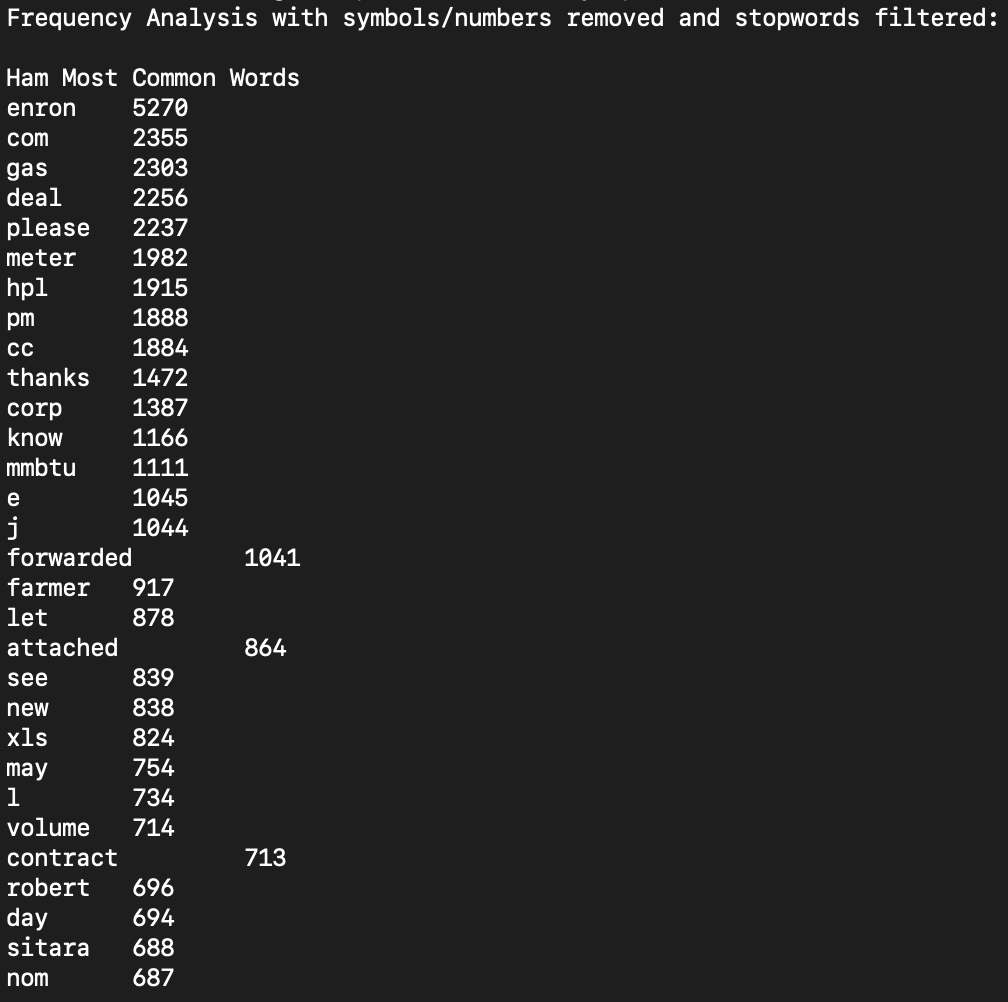

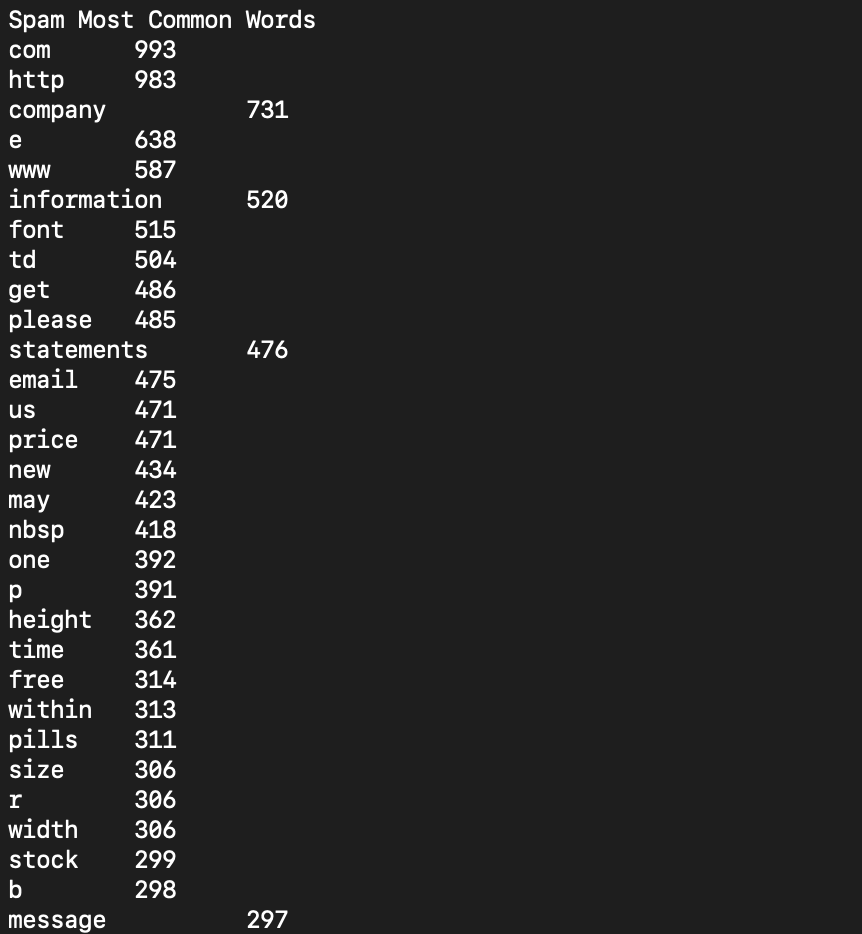

## Feature 2: Bigram Creation and Frequency Analysis

Feature 2 takes in an tokenized list and returns the top 30 most common bigrams from the list.

In [ ]:
#feature function 2: bigram frequency analysis

def bigrams(hamList, spamList):
  hamFinder = nltk.collocations.BigramCollocationFinder.from_words(hamList)
  commonBigrams = hamFinder.ngram_fd.most_common(30)
  print("\nHam Most Common Bigrams")
  for bigram in commonBigrams:
    print(bigram[0],'\t', bigram[1])

  spamFinder = nltk.collocations.BigramCollocationFinder.from_words(spamList)
  commonBigrams = spamFinder.ngram_fd.most_common(30)
  print("\nSpam Most Common Bigrams")
  for bigram in commonBigrams:
    print(bigram[0],'\t',bigram[1])


In def main(), the following code was used to return the results displayed in the screenshot:

In [ ]:
emaildocs, spamtexts, hamtexts = processSpamHam(sys.argv[1], sys.argv[2])
hamTokens, spamTokens, emaildocsTokenized, hamAlpha, spamAlpha, emaildocsAlpha, hamStop, spamStop, emaildocsStop = cleanUpCleanUp(emaildocs)

print("Top 30 bigrams using list with symbols/numbers removed and stopwords filtered:")
bigrams(hamStop,spamStop)

Frequency Analysis with symbols/numbers removed and stopwords filtered:


NameError: ignored

This screenshot shows the bigrams using the cleaned and filtered data lists. Within these bigrams, there are several phrases which are unsurprisingly at the top of the Spam list. Phrases such as (href,http), (http, www), and (investment, advice). These phrases will likely remain somewhat consistent across varied data sets. The ham bigrams have a higher likelihood of changing completely depending on the company from which the ham emails are sourced or the primary writers of the emails.

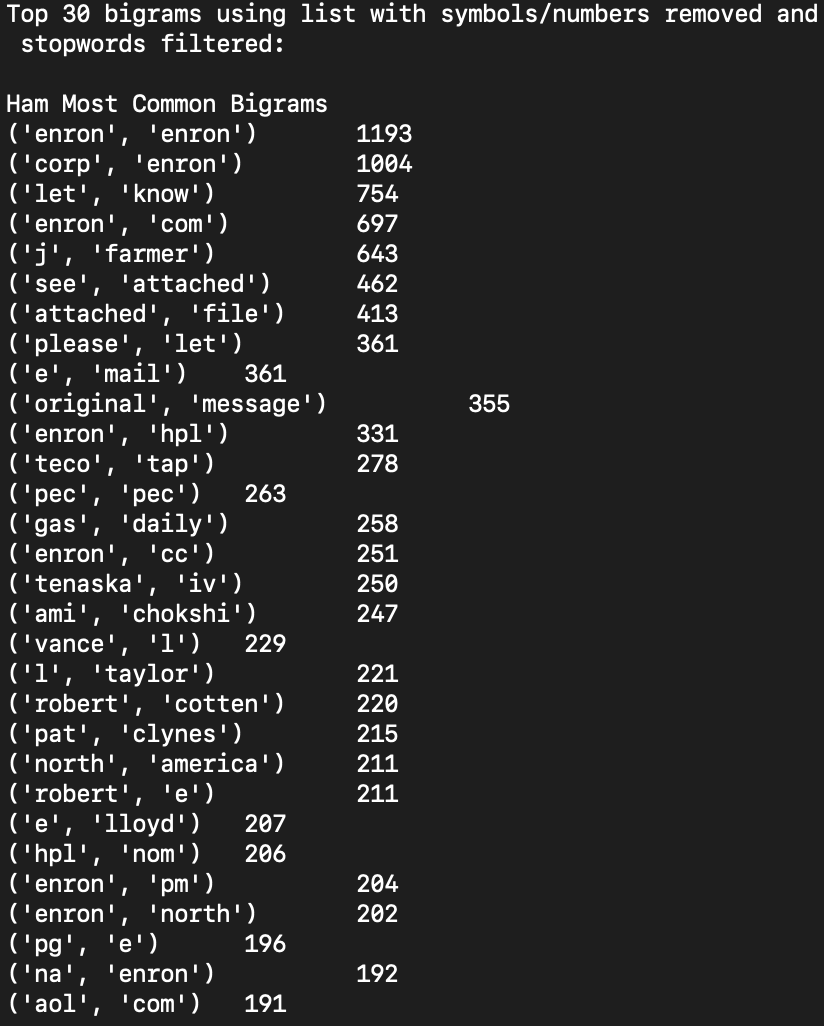

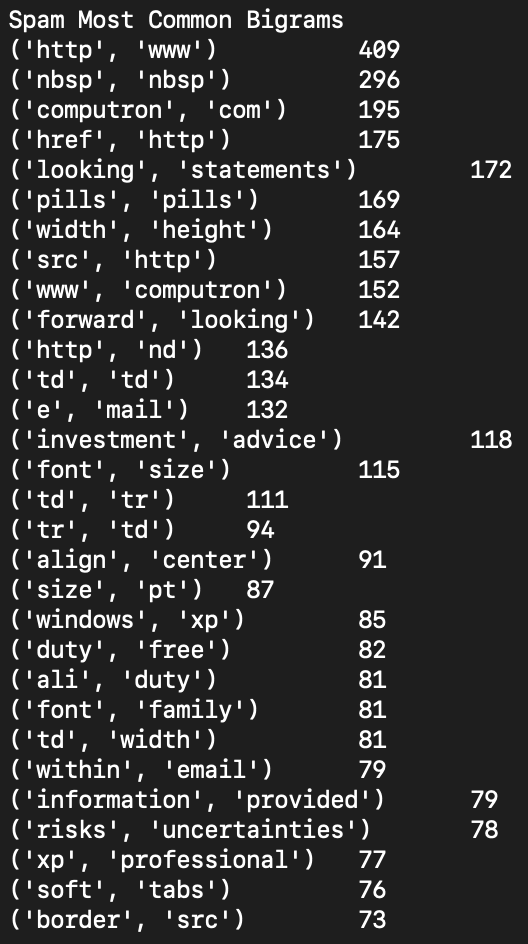

## Feature 3: Trigram Creation and Frequency Analysis

Feature 3 takes in an tokenized list and returns the top 30 most common trigrams from the list.

In [ ]:
def trigrams(hamList, spamList):
  hamFinder = nltk.collocations.TrigramCollocationFinder.from_words(hamList)
  commonTrigrams = hamFinder.ngram_fd.most_common(30)
  print("\nHam Most Common Trigrams")
  for trigram in commonTrigrams:
    print(trigram[0],'\t', trigram[1])

  spamFinder = nltk.collocations.TrigramCollocationFinder.from_words(spamList)
  commonTrigrams = spamFinder.ngram_fd.most_common(30)
  print("\nSpam Most Common Trigrams")
  for trigram in commonTrigrams:
    print(trigram[0],'\t',trigram[1])

In def main(), the following code was used to return the results displayed in the screenshot:

In [ ]:
emaildocs, spamtexts, hamtexts = processSpamHam(sys.argv[1], sys.argv[2])
hamTokens, spamTokens, emaildocsTokenized, hamAlpha, spamAlpha, emaildocsAlpha, hamStop, spamStop, emaildocsStop = cleanUpCleanUp(emaildocs)

print("Top 30 trigrams using list with symbols/numbers removed and stopwords filtered:")
trigrams(hamStop,spamStop)

Frequency Analysis with symbols/numbers removed and stopwords filtered:


NameError: ignored

This screenshot shows the trigrams using the cleaned and filtered data lists. The analysis of the trigrams remains consistent with that of the bigrams: the most common spam phrases are expected and will likely remain consistent across datasets. However, the most common ham trigrams are specific to the content and origin of the ham corpus of emails.

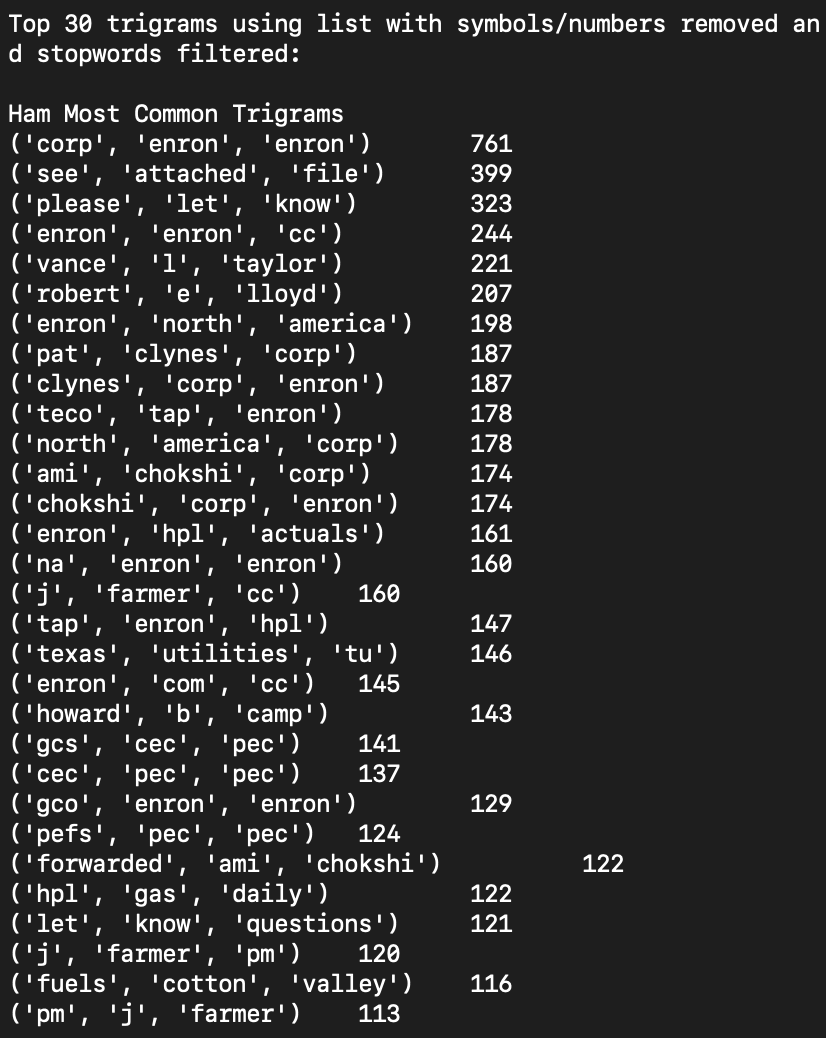

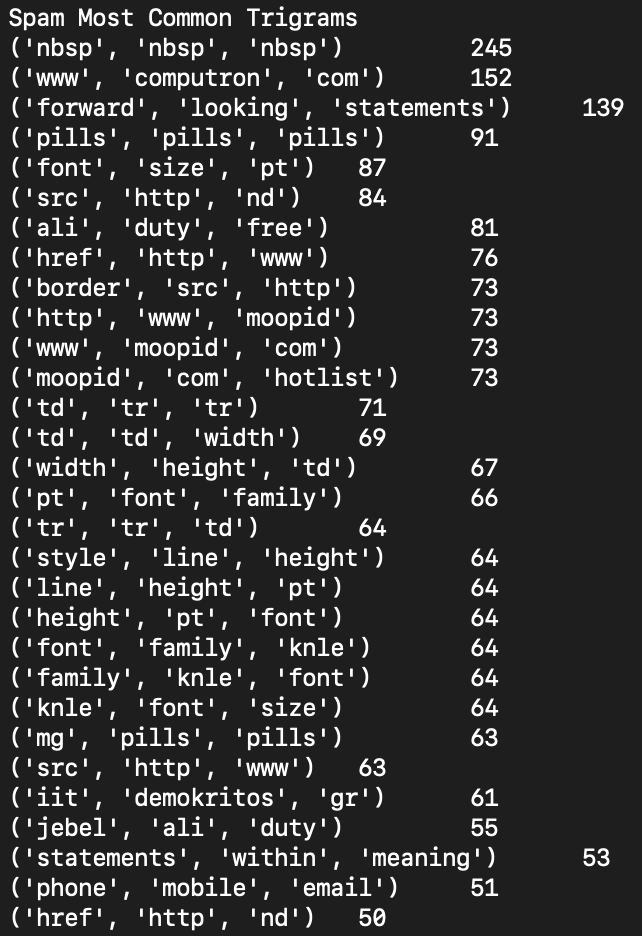

## Feature 4: Sentiment Analysis

Feature 4 uses the sentiment intensity analyzer included in the NLTK to score each email's sentiment. The SIA returns various types of sentiment scores using the VADER module.  In this feature, the team chose to focus on the compound score to separate positive and negative emails. If an email's compound score is greater than 0, it is classifed as positive. If it is less than 0, it is negative. It returns a list of tuples with the email, the compound score, and it's label of "positive"/"negative."

In [ ]:
def sentimentAnalysis(spamtexts, hamtexts):
  #guidance from the following site: https://realpython.com/python-nltk-sentiment-analysis/

  # initialize sentiment analyzer included in nltk
  sia = SentimentIntensityAnalyzer()
  # initialize lists
  spamSentimentList = []
  hamSentimentList = []
  # using only the compound score from the sia, sort the emails into positive and negative lists
  # start with spam
  for email in spamtexts:
    compoundScore = sia.polarity_scores(email)["compound"]
    if compoundScore > 0:
      spamSentimentList.append((email, compoundScore, 'positive'))
    else:
      spamSentimentList.append((email, compoundScore, 'negative'))
  # now do ham
  for email in hamtexts:
    compoundScore = sia.polarity_scores(email)["compound"]
    if compoundScore > 0:
      hamSentimentList.append((email, compoundScore, 'positive'))
    else:
      hamSentimentList.append((email, compoundScore, 'negative'))
  # output: spamSentimentList, hamSentimentList
  #    each list will contain a triple tuple with tokenized email, sentiment score, "positive"/"negative"

  return (spamSentimentList, hamSentimentList)


In def main(), the following code was used to return the results displayed in the screenshot:

In [ ]:
emaildocs, spamtexts, hamtexts = processSpamHam(sys.argv[1], sys.argv[2])
hamTokens, spamTokens, emaildocsTokenized, hamAlpha, spamAlpha, emaildocsAlpha, hamStop, spamStop, emaildocsStop = cleanUpCleanUp(emaildocs)
joinedEmailList, joinedEmailList = join(emaildocsStop, emaildocsStop)
testList, trainList = trainTestSplit(emaildocsStop)
joinedTestList, joinedTrainList = join(testList,trainList)

testSentimentList, trainSentimentList = sentimentAnalysis(joinedTestList, joinedTrainList)

for item in testSentimentList:
  print(item,"\n")

IndentationError: ignored

This screenshot shows the sentiment analysis output seperated by positive and negative, spam and ham. The majority of emails were classified as positive. Given additional time and data, for further analytical value, a classifier could be trained using sentiment. Although if sentiment analysis were to be applied to testing and training a classifier, the team would recommend creating additional categories for "extremely positive" or "extremely negative" to add more refined classifications to the dataset.

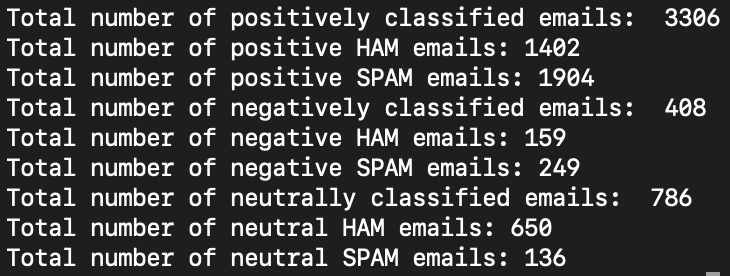
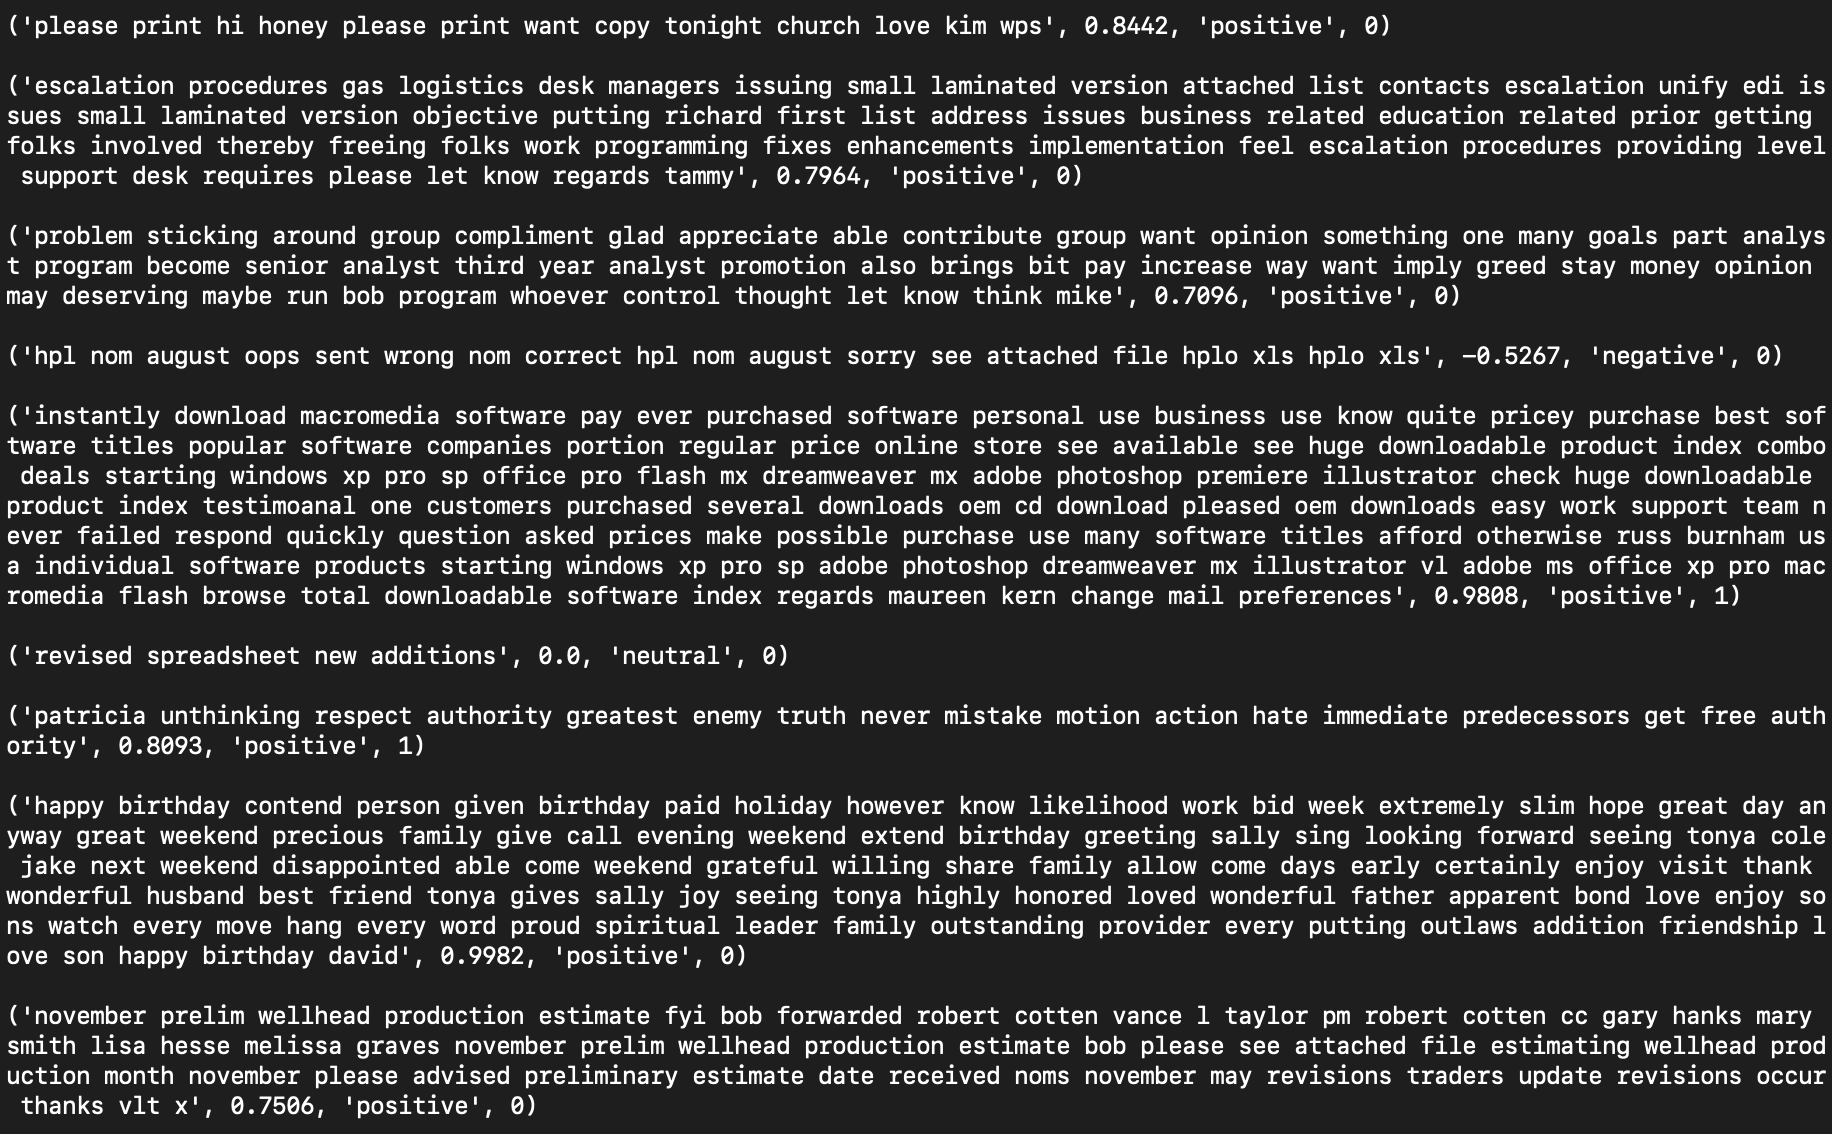

# STEP 3: EXPERIMENTS

# Text Classification Experiments

## Multinomial Naive Bayes

An example of using an Sklearn classifier with features produced in NLTK. The classifier being Multinomial Naive Bayes and the produced features are the numerical representations of the text data being ran through MNB that were produced using CountVectorizer. The process of MNB is as follows: each document, in this case each text/email file, is converted into a list of features, i.e. words, and then the number of times that unique word is present in all of the texts is recorded, and a data frame of these frequencies is created. In this case, every column in the data frame is a unique word that appears in 1 or more text files. The corresponding rows contain whether or not that word appears in the text file it is counting for and there is a label column that contains either "spam" or "ham" in the training data, which MNB will use to predict classifications. The output prediction is the model's probability that each set of words would belong to spam or ham. MNB is a good choice for our task because it is both efficient and simple, and effective working with text data. It also usually performs well and the output is easily readable.
In pre-processing this set of data, in order to run MNB in a timely fashion, a random sample of the data was selected and used. Without taking a random sample, it was ran for over 24 hours and ultimately the computer did not have enough memory. As for cleaning the new set, first, the data is stemmed and made lowercase. Below, a stemmer function was created. Stemming was not done for the other experiments, and was used in this case simply out of curiosity and a desire to see its effect, if any, on the outcome of accuracy and prediction. Pre-processing is extremely important for running MNB because it does take a very long time to run and cutting down on running extraneous words is helpful. For example, it is easier to run "sit", instead of all four of the following: "sat", "sitting", "sits", and "Sit."

In [ ]:
#this creates a function to stem the words
STEMMER=PorterStemmer()
print(STEMMER.stem("fishings"))

fish


In [ ]:
def MY_STEMMER(str_input):
    words = re.sub(r"[^A-Za-z\-]", " ", str_input).lower().split()
    words = [STEMMER.stem(w) for w in words]
    return words

Next, a vectorizer was set up using CountVectorizer, that also included removing stop words, making all words lowercase for consistency and decreasing the amount of duplicate tokens, stemming, and tokenizing.

In [ ]:
#this is setting up the count vectorizer we will use later, removing stop words, and making things lowercase for consistency
MyVect_STEM=CountVectorizer(input='filename',
                        analyzer = 'word',
                        stop_words='english',
                        tokenizer=MY_STEMMER,
                        lowercase = True
                        )

A function was created to remove all numbers that would be a column in the vectorized data frame just to see its effect on the accuracy and prediction, and simply as another cleaning step as much of the data included extraneous material and symbols.

In [ ]:
#this function removes numbers that will be used later
def RemoveNums(SomeDF):
    print("Running Remove Numbers function....\n")
    temp=SomeDF
    MyList=[]
    for col in temp.columns:
        Logical2=str.isalpha(col)
        if(Logical2==False):
            MyList.append(str(col))
    temp.drop(MyList, axis=1, inplace=True)

    return temp

An empty data frame is established that will then house the vectorized data frame.

In [ ]:
#setting up an empty data frame to put the vectorized words into
FinalDF_STEM=pd.DataFrame()

Below is where the data is read in , cleaned, and vectorized simultaneously. One of the columns is "label" which is "spam" or "ham" indicating which classification each email has, and the words in these emails is indicated with a number, "1.0" for its inclusion or "0.0" if not.

In [ ]:
#below is where you read in the files
#you need to put the two folders ham and spam in another folder (I titled mine corpus)
#I put spam and ham in corpus so the path is C:/Users/bradr/Desktop/g/corpus/ so just replace path below with #your own and everything else should work the same
for name in ["spam","ham"]:

    builder=name+"DF"
    builderB=name+"DFB"

    path="C:/Users/bradr/Desktop/g/corpus123/"+name

    FileList=[]
    for item in os.listdir(path):
        next1=path+ "/" + item
        #appends each file (txt file) into a list
        FileList.append(next1)
        #this is where the vectorization happens
        X1=MyVect_STEM.fit_transform(FileList)
        #getting all of the vectorized word names
        ColumnNames1=MyVect_STEM.get_feature_names_out()
        NumFeatures1=len(ColumnNames1)
        #building a column of labels i.e. spam or ham
        builderS=pd.DataFrame(X1.toarray(),columns=ColumnNames1)
        builderS["Label"]=name
        #adding the labels column to the rest of the vectorized data frame
        FinalDF_STEM=pd.concat([FinalDF_STEM, builderS], ignore_index=True)


Output:

In [ ]:
full list...
full list...
full list...
full list...
full list...
full list...
full list...
full list...
full list...
full list...
C:\Users\bradr\Desktop\Python\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\bradr\Desktop\Python\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
C:\Users\bradr\Desktop\Python\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\bradr\Desktop\Python\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\bradr\Desktop\Python\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

In [ ]:
print(FinalDF_STEM.head())
print(FinalDF_STEM['Label'])

Below is a look at the code before NAs are removed, and the labels for each text file. As you can see there are some notable typos on the end, and possibly some incorrectly stemmed words like "christma" as opposed to "christmas".

In [ ]:
   christma  farm  pictur  subject  ...  worsen wristband  yaound  yardag
0       1.0   1.0     1.0        1  ...     NaN       NaN     NaN     NaN
1       1.0   1.0     1.0        1  ...     NaN       NaN     NaN     NaN
2       0.0   0.0     0.0        4  ...     NaN       NaN     NaN     NaN
3       1.0   1.0     1.0        1  ...     NaN       NaN     NaN     NaN
4       0.0   0.0     0.0        4  ...     NaN       NaN     NaN     NaN

[5 rows x 10777 columns]
0         ham
1         ham
2         ham
3         ham
4         ham

78848    spam
78849    spam
78850    spam
78851    spam
78852    spam
Name: Label, Length: 78853, dtype: object

More cleaning is done below, removing NAs, removing numbers, and then the training and test data is split 70/30.

In [ ]:
#this replaces all columns that have NaN with 0
FinalDF_STEM=FinalDF_STEM.fillna(0)
#this is the use of the remove numbers function
FinalDF_STEM=RemoveNums(FinalDF_STEM)


#splitting the data into training and test data
TrainDF3, TestDF3 = train_test_split(FinalDF_STEM, test_size=0.3)
Test3Labels=TestDF3["Label"]

Below, the label column is removed in order to use MNB, otherwise it would not run.

In [ ]:
#removing the label column because you are using the labels column for the algorithm
TestDF3 = TestDF3.drop(["Label"], axis=1)
Train3Labels=TrainDF3["Label"]
TrainDF3 = TrainDF3.drop(["Label"], axis=1)

In [ ]:
#setting up an instance of mnb
MyModelNB1= MultinomialNB()

In [ ]:
#running MNB on the data and labels, using the labels and training data
MyModelNB1.fit(TrainDF3, Train3Labels)

In [ ]:
#making a prediction from MNB
Prediction1 = MyModelNB1.predict(TestDF3)

In [ ]:
print("\nThe prediction from NB is:")
print(Prediction1)
print("\nThe actual labels are:")
print(Test3Labels)

Below is the prediction that would go on for many rows, so only a snippet is shown. A glimpse can be seen of the accuracy of the model given that the model accurately predicted all 6 of the predictions shown below.

In [ ]:
The prediction from NB is:
['ham' 'ham' 'spam' ... 'ham' 'ham' 'spam']

The actual labels are:
8121      ham
27050     ham
68255    spam
73369    spam
4746      ham

37650     ham
57528     ham
51567     ham
18196     ham
77153    spam
Name: Label, Length: 23656, dtype: object

In [ ]:
#confusion matrix
cnf_matrix3 = confusion_matrix(Test3Labels, Prediction1)

In [ ]:
print("\nThe confusion matrix is:")
print(cnf_matrix3)

### prediction probabilities
## columns are the labels in alphabetical order
## The decimal in the matrix are the prob of being
## that label (ham or spam)
#each column represents the predicted probability of a specific class
print(np.round(MyModelNB1.predict_proba(TestDF3),2))

In [ ]:
The confusion matrix is:
[[20206     0]
 [   88  3362]]

 [[1.   0.  ]
 [1.   0.  ]
 [0.   1.  ]
 ...
 [1.   0.  ]
 [1.   0.  ]
 [0.07 0.93]]

The results: there were 20206 emails correctly classified as not spam, 88 non-spam emails incorrectly classified, and 3362 spam emails correctly classified. This model is relatively effective in identifying spam emails in terms of ratios with an accuracy of 87.98%. However, it is to be noted that there were 0 incorrectly classified instances for non-spam emails, this might also indicate overfitting of the model and reduces its effectiveness in evaluating the difference between spam and ham emails.

In [ ]:
The confusion matrix is:
[[20317     0]
 [    0  3339]]

[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]

The results above are the result of the same code as before but without any data cleaning. The words were not stemmed, or made lowercase, no numbers were removed, nor were stop words removed, but all NaN's were removed, because MNB will not run with NAs. This 100% accuracy seems to be indicative of overfitting of the model. This in turn suggests that this model is ineffective in classifying the emails as spam or ham with no form of data pre-processing. This shows that the model is unable to generalize and apply to future classifications of spam or ham since it aligns perfectly with the training dataset provided.

In all, despite MNB being a very useful tool for text classifications a majority of the time, for our purposes it was not entirely effective. This could ultimately have a majority of factors. If we had a computer with double the memory, it is possible we could have output a much more suitable confusion matrix and probability that would instill confidence in the model. By taking a smaller percentage of the emails,

## Classification Function: Gaussian NB, Multinomial NB, Bernoulli NB


Vectorizers: bag of words, TFIDF

Classifiers: GaussianNB, MultinomialNB, BernoulliNB

This function takes the processed, cleaned, re-joined, and train/test split lists as input (joinedTestList, joinedTrainList). Additionally, it accepts a string that specifies the vectorizer type (bag of words, TFIDF) and the classifier type (GaussianNB, MultinomialNB, BernoulliNB).

In our initial classification experiments, the team chose to use sklearn to vectorize our corpus data and train/test our models.

This function splits the input list values into X and Y data sets: X = email data, Y = label data. It feeds the training data into the vectorizer to return a 2-D document-term matrix. It then transforms the matrix into a dense array because that is the format required for using the training data to fit the classifier. The specified classifier is trained using the email data and labels. Next, the model's accuracy is tested by using the remaining test data. The classifier.predict module gets the model's predictions for the email classification, and, finally, we compare the predictions with the actual spam/ham classification.

The function returns a trained classifier to use in our cross fold validation experimenting.


In [ ]:
def classyClassy(joinedTestList,joinedTrainList, vectorizerType, classifierType):
    #using guidance from: https://www.shiksha.com/online-courses/articles/spam-filtering-using-bag-of-words/#sklearn
    #using guidance from: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.transform
    #using guidance from: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB.fit
    #using guidance from: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

    justTextTrain = []
    for item in joinedTrainList:
        justTextTrain.append(item[0])
    justTextTest = []
    for item in joinedTestList:
        justTextTest.append(item[0])

    justLabelTrain = []
    for item in joinedTrainList:
        justLabelTrain.append(item[1])
    justLabelTest = []
    for item in joinedTestList:
        justLabelTest.append(item[1])

    #this will take in just the x-values in the (x,y)/(email,label) pair
    if vectorizerType == "bag of words":
        #bag of words
        vectorizer = CountVectorizer(max_features=100)
    elif vectorizerType == "TFIDF":
        #TFIDF vectorizer: creating training array using TFIDF vectorizer
        vectorizer = TfidfVectorizer(max_features=100)
    else:
        print("Please input a valid vectorizer type.")
        quit()

    #learn the vocabulary dictionary and return 2-D document-term matrix.
    #   equivalent to fit followed by transform, but more efficiently implemented.
    #   document-term matrix is a sparse matrix
    Xtrain = vectorizer.fit_transform(justTextTrain,justLabelTrain)

    #will return a dictionary that is mapping terms to feature indices.
    #print("Vocab:",vectorizer.vocabulary_)

    #intialize classifier
    if classifierType == "GaussianNB":
        classifier = GaussianNB()
    elif classifierType == "MultinomialNB":
        classifier = MultinomialNB()
    elif classifierType == "BernoulliNB":
        classifier = BernoulliNB()
    else:
        print("Please input a valid classifier type.")
        quit()

    #Xtrain.toarray() because dense numpy array is required for classifier.fit
    classifier.fit(Xtrain.toarray(), justLabelTrain)

    Xtest = vectorizer.fit_transform(justTextTest,justLabelTest)

    yPred = classifier.predict(Xtest.toarray())

    accuracy = accuracy_score(justLabelTest, yPred)

    print("The following scores were obtained using", vectorizerType,"and",classifierType,":")
    print("Accuracy score: ", accuracy*100,"%")
    print("Precision score: ",precision_score(justLabelTest, yPred))
    print("Confusion matrix: ")
    print(confusion_matrix(justLabelTest,yPred))
    print("F1 score: ",f1_score(justLabelTest, yPred))
    print("Recall score: ",recall_score(justLabelTest, yPred))

    return classifier

In def main(), the following code was used to return the results displayed in the screenshot:

In [ ]:
emaildocs, spamtexts, hamtexts = processSpamHam(sys.argv[1], sys.argv[2])
hamTokens, spamTokens, emaildocsTokenized, hamAlpha, spamAlpha, emaildocsAlpha, hamStop, spamStop, emaildocsStop = cleanUpCleanUp(emaildocs)
joinedEmailList, joinedEmailList = join(emaildocsStop, emaildocsStop)
testList, trainList = trainTestSplit(emaildocsStop)
joinedTestList, joinedTrainList = join(testList,trainList)

classifier = classyClassy(joinedTestList, joinedTrainList, "TFIDF", "GaussianNB")
print()
classifier = classyClassy(joinedTestList, joinedTrainList, "bag of words", "GaussianNB")

NameError: ignored

This screenshot shows the accuracy score, precision score, confusion matrix, F1 score, and recall score for each classifier used. GaussianNB + TFIDF was used in the top output, and GuassianNB + bag of words was used in the bottom model.

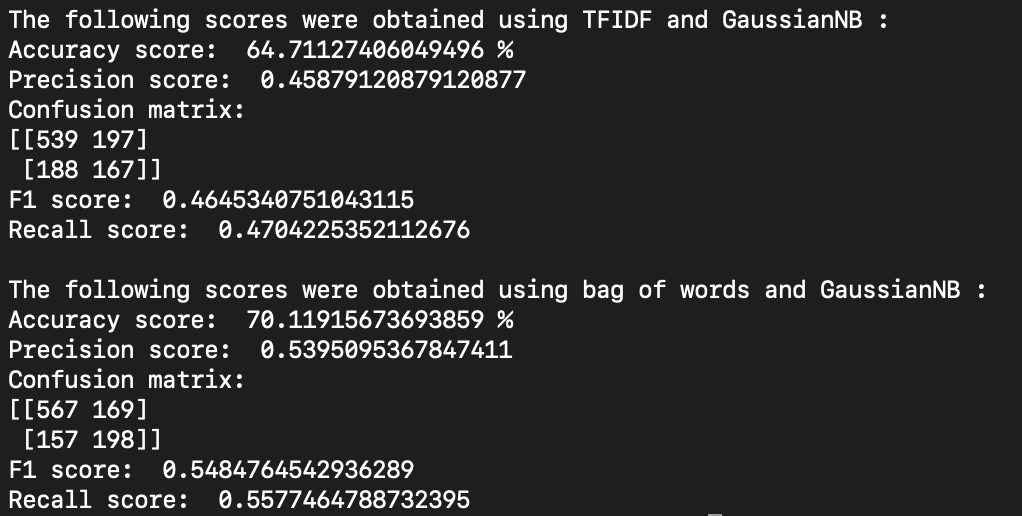

## K-Fold Cross Validation

K-Fold cross validation allows us to find an average accuracy value which ensures we don't overfit our model. This allows us to get a more realistic assessment of which type of vectorizer/classifier combination is most effective in classifying the emails.

The function below takes in the classifier returned from the classification function that was trained on a subset of data. Then it splits the remaining test data into however many folds is specified in the input and tests the classifier against each of those subsets of data. After each subset, it gets an accuracy score, and the function returns a final average accuracy score from each test.

In [ ]:
def crossFoldValidation(classifier,vectorizerType,emaildocsStop,crossFoldNum,OGtestList):
    sameNewList = OGtestList.copy()
    #this will take in just the x-values in the (x,y)/(email,label) pair
    if vectorizerType == "bag of words":
        #bag of words
        vectorizer = CountVectorizer(max_features=100)
    elif vectorizerType == "TFIDF":
        #TFIDF vectorizer: creating training array using TFIDF vectorizer
        vectorizer = TfidfVectorizer(max_features=100)
    else:
        print("Please input a valid vectorizer type.")
        quit()

    accuracyMeanAll = 0

    splitLen = len(OGtestList)/crossFoldNum
    splitLen = math.floor(splitLen)

    #keep going until there is nothing remaining in the OGTestList
    while len(OGtestList) > 0:
      j = splitLen
      justTextTest = []
      justLabelTest = []
      #create little lists on which we perform our accuracy tests. Because we divided our original
      #  list length by the cross validation value, we will be creating crossFoldNum lists
      while j >= 0 and len(OGtestList) > 0:
        item = OGtestList[0]
        justTextTest.append(item[0])
        justLabelTest.append(item[1])
        OGtestList.pop(0)
        j = j-1

      Xtest = vectorizer.fit_transform(justTextTest,justLabelTest)
      yPred = classifier.predict(Xtest.toarray())

      accuracy = accuracy_score(justLabelTest, yPred)
      accuracyMeanAll = accuracyMeanAll + accuracy

    meanAccuracy = accuracyMeanAll/crossFoldNum
    meanPercent = meanAccuracy*100
    print(meanPercent,"% accuracy using k-fold cross validation with",crossFoldNum,"folds.")
    return meanAccuracy, sameNewList

In def main(), the following code was used to return the results displayed in the screenshot:

In [ ]:
emaildocs, spamtexts, hamtexts = processSpamHam(sys.argv[1], sys.argv[2])
hamTokens, spamTokens, emaildocsTokenized, hamAlpha, spamAlpha, emaildocsAlpha, hamStop, spamStop, emaildocsStop = cleanUpCleanUp(emaildocs)
joinedEmailList, joinedEmailList = join(emaildocsStop, emaildocsStop)
testList, trainList = trainTestSplit(emaildocsStop)
joinedTestList, joinedTrainList = join(testList,trainList)

classifier = classyClassy(joinedTestList, joinedTrainList, "TFIDF", "GaussianNB")
meanAccuracy, sameNewList = crossFoldValidation(classifier,"TFIDF",emaildocsStop,10,joinedTestList)
print()
classifier = classyClassy(joinedTestList, joinedTrainList, "bag of words", "GaussianNB")
meanAccuracy, sameNewList = crossFoldValidation(classifier,"bag of words",emaildocsStop,10,sameNewList)
print()
classifier = classyClassy(sameNewList, joinedTrainList, "TFIDF", "MultinomialNB")
meanAccuracy, sameNewList = crossFoldValidation(classifier,"TFIDF",emaildocsStop,10,sameNewList)
print()
classifier = classyClassy(sameNewList, joinedTrainList, "bag of words", "MultinomialNB")
meanAccuracy, sameNewList = crossFoldValidation(classifier,"bag of words",emaildocsStop,10,sameNewList)
print()
classifier = classyClassy(sameNewList, joinedTrainList, "TFIDF", "BernoulliNB")
meanAccuracy, sameNewList = crossFoldValidation(classifier,"TFIDF",emaildocsStop,10,sameNewList)
print()
classifier = classyClassy(sameNewList, joinedTrainList, "bag of words", "BernoulliNB")
meanAccuracy, sameNewList = crossFoldValidation(classifier,"bag of words",emaildocsStop,10,sameNewList)

NameError: ignored

This screenshot shows the mean accuracy score for every possible combination of NB classifier and vectorizer the team included in our classification function using 10-fold cross validation. From this data, the team could draw a few major conclusions within the confines of this project and using this data:

1) The classifier used results in a larger difference in accuracy as opposed to the vectorizer method.
2) BernoulliNB was the most effective classifier.

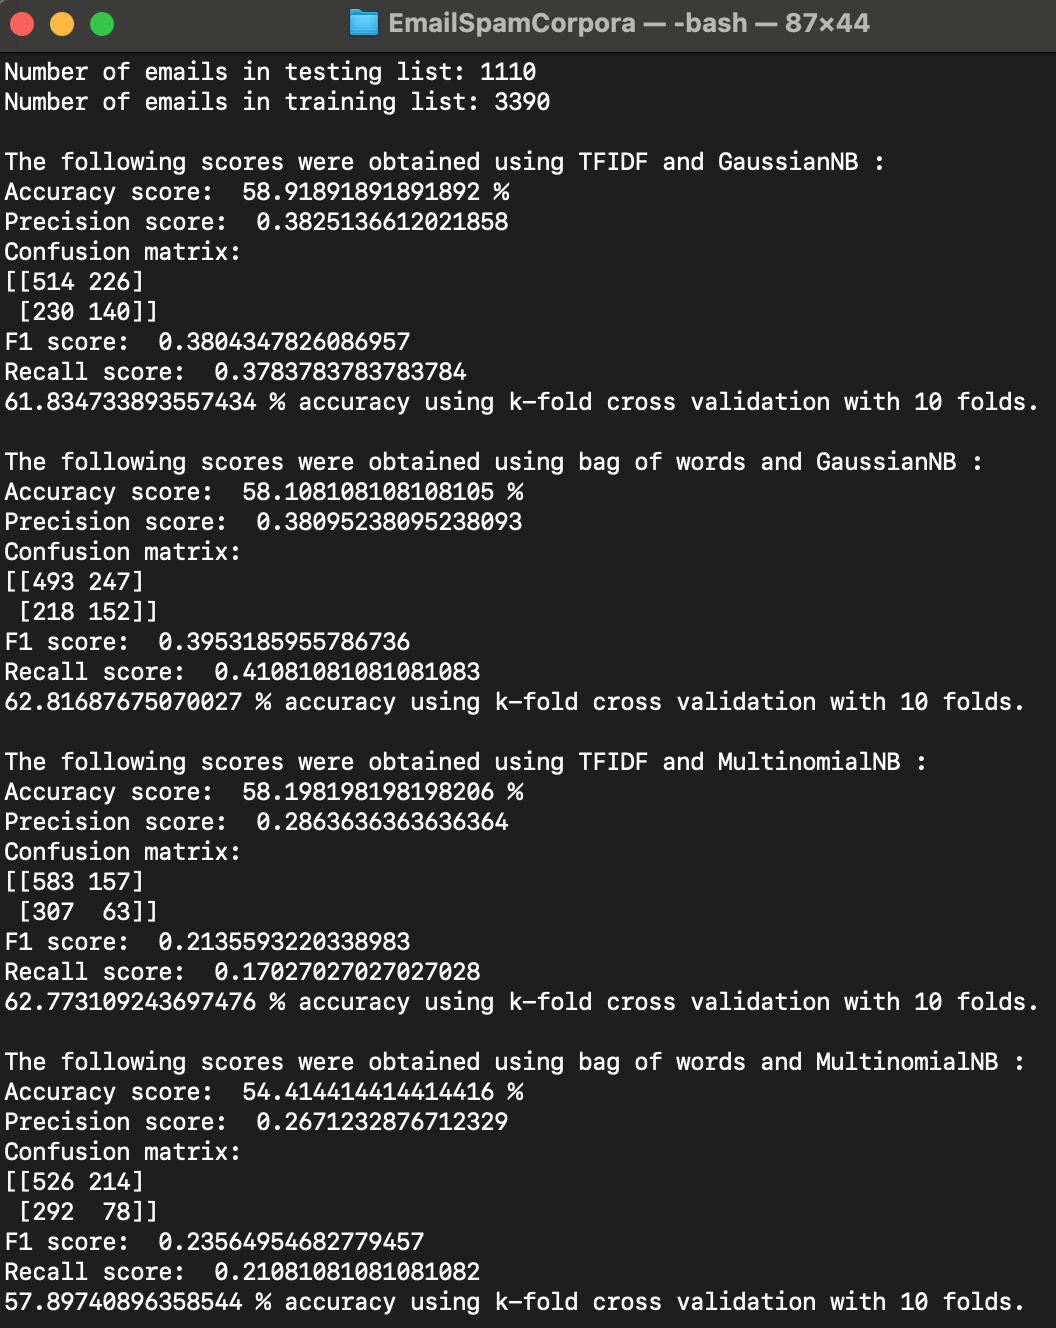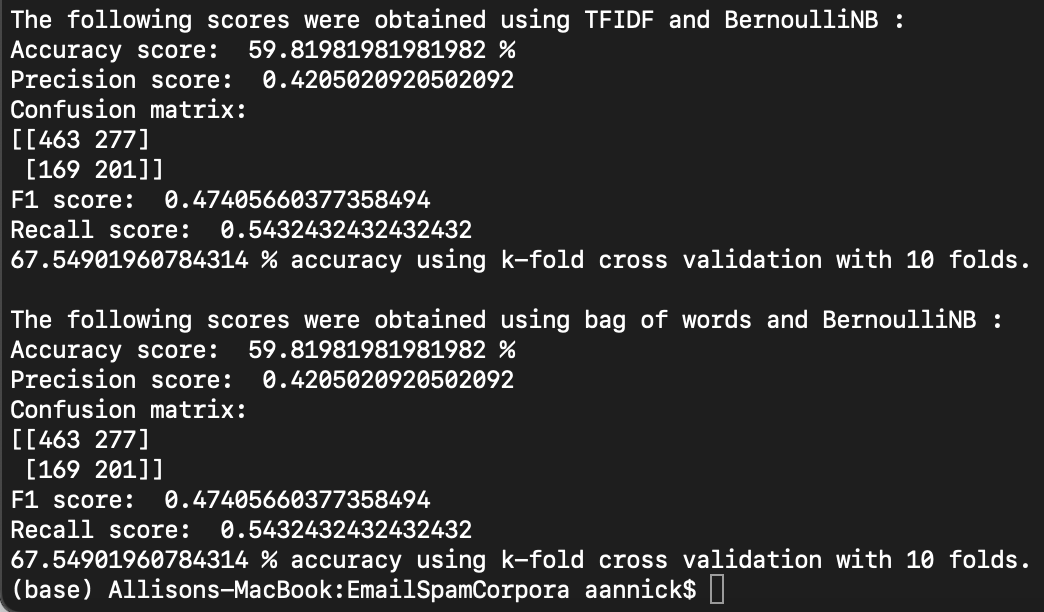

## Main Function: runs Data Processing, Feature Functions 1-4, and Classification Function


In [ ]:
def main():
  emaildocs, spamtexts, hamtexts = processSpamHam(sys.argv[1], sys.argv[2])
  hamTokens, spamTokens, emaildocsTokenized, hamAlpha, spamAlpha, emaildocsAlpha, hamStop, spamStop, emaildocsStop = cleanUpCleanUp(emaildocs)

  #need joined list, but still want two inputs in the join() function, SO input the same list twice just so it works
  #computationally, not the best solution, but functionally necessary
  joinedEmailList, joinedEmailList = join(emaildocsStop, emaildocsStop)

  #toCSV(joinedEmailList)
  #print("Frequency Analysis using lists with symbols/numbers:")
  #frequencyAnalysis(hamTokens,spamTokens)

  #print("Frequency Analysis with symbols/numbers filtered:")
  #frequencyAnalysis(hamAlpha,spamAlpha)

  #print("Frequency Analysis with symbols/numbers removed and stopwords filtered:")
  #frequencyAnalysis(hamStop,spamStop)

  #print("Top 30 bigrams using list with symbols/numbers removed and stopwords filtered:")
  #bigrams(hamStop,spamStop)

  #print("Top 30 trigrams using list with symbols/numbers removed and stopwords filtered:")
  #trigrams(hamStop,spamStop)

  testList, trainList = trainTestSplit(emaildocsStop)
  joinedTestList, joinedTrainList = join(testList,trainList)
  #testSentimentList, trainSentimentList = sentimentAnalysis(joinedTestList, joinedTrainList)

  #for item in testSentimentList:
    #print(item,"\n")
    #print()
  #print(testSentimentList, trainSentimentList)

  #input to this function requires a vectorizer type of: "bag of words" OR "TFIDF"
  # and a classifier type of: "GaussianNB" OR "MultinomialNB" OR "BernoulliNB"
  classifier = classyClassy(joinedTestList, joinedTrainList, "TFIDF", "GaussianNB")
  meanAccuracy, sameNewList = crossFoldValidation(classifier,"TFIDF",emaildocsStop,10,joinedTestList)
  print()
  classifier = classyClassy(joinedTestList, joinedTrainList, "bag of words", "GaussianNB")
  meanAccuracy, sameNewList = crossFoldValidation(classifier,"bag of words",emaildocsStop,10,sameNewList)
  print()
  classifier = classyClassy(sameNewList, joinedTrainList, "TFIDF", "MultinomialNB")
  meanAccuracy, sameNewList = crossFoldValidation(classifier,"TFIDF",emaildocsStop,10,sameNewList)
  print()
  classifier = classyClassy(sameNewList, joinedTrainList, "bag of words", "MultinomialNB")
  meanAccuracy, sameNewList = crossFoldValidation(classifier,"bag of words",emaildocsStop,10,sameNewList)
  print()
  classifier = classyClassy(sameNewList, joinedTrainList, "TFIDF", "BernoulliNB")
  meanAccuracy, sameNewList = crossFoldValidation(classifier,"TFIDF",emaildocsStop,10,sameNewList)
  print()
  classifier = classyClassy(sameNewList, joinedTrainList, "bag of words", "BernoulliNB")
  meanAccuracy, sameNewList = crossFoldValidation(classifier,"bag of words",emaildocsStop,10,sameNewList)

  #sentimentClassifer(testSentimentList, trainSentimentList, "bag of words", "MultinomialNB")
  #LIWC(emaildocsStop)


## Using TensorFlow to Detect Spam Emails

In [ ]:
data = pd.read_csv('out.csv')
data

,Category,Message
0,spam,get prescri ption rugs door
1,ham,revision black marlin meter ua yes right howar...
2,ham,november real estate news update hi november t...
3,ham,equistar deal tickets going deal get resolved ...
4,ham,new book please create following books used si...
...,...,...
4495,spam,onlinepharmacycheap sergio hoffmann psychother...
4496,ham,fw fw ena gas sales hpl h gas company deal ext...
4497,ham,gulf coast pipeline company dyersdale area har...
4498,ham,enron hpl actuals january teco tap enron


In [ ]:
# Printing some sample lines from the dataset
print(data.shape, "\n")
print(data.head())

(4500, 2) 

  Category                                            Message
0     spam                        get prescri ption rugs door
1      ham  revision black marlin meter ua yes right howar...
2      ham  november real estate news update hi november t...
3      ham  equistar deal tickets going deal get resolved ...
4      ham  new book please create following books used si...


In [ ]:
# Using a lammbda function to replace the variable "Category", where "ham" = 0 and "spam" = 1
data['Category'] = data['Category'].apply(lambda x:1 if x=='spam' else 0)

In [ ]:
data.head()

,Category,Message
0,1,get prescri ption rugs door
1,0,revision black marlin meter ua yes right howar...
2,0,november real estate news update hi november t...
3,0,equistar deal tickets going deal get resolved ...
4,0,new book please create following books used si...


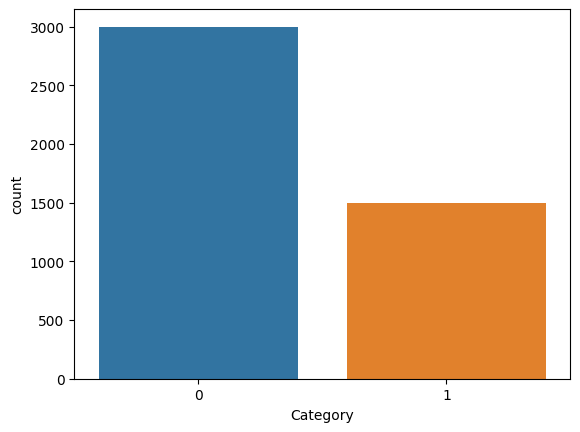

In [ ]:
# Printing a graph showing the number of Spam emails vs. number of Non-Spam emails
sns.countplot(x='Category', data=data)
plt.show()

The next several lines of code goes through each email and removes NaNs, stopwords, and characters/punctuation that are in each email

In [ ]:
punctuations_list = string.punctuation

In [ ]:
def remove_punctuations(text):
   temp = str.maketrans('', '', punctuations_list)
   return text.translate(temp)

In [ ]:
data = data.dropna()
data['Message'] = data['Message'].apply(lambda x: remove_punctuations(x))
data.head()

<ipython-input-57-eedcce61d93f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Message'] = data['Message'].apply(lambda x: remove_punctuations(x))


,Category,Message
0,1,get prescri ption rugs door
1,0,revision black marlin meter ua yes right howar...
2,0,november real estate news update hi november t...
3,0,equistar deal tickets going deal get resolved ...
4,0,new book please create following books used si...


In [ ]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)
    output = " ".join(imp_words)
    return output

In [ ]:
# Sample of emails after having their stopwords and characters removed
data['Message'] = data['Message'].apply(lambda text: remove_stopwords(text))
data.head()

<ipython-input-59-206b893b7368>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Message'] = data['Message'].apply(lambda text: remove_stopwords(text))


,Category,Message
0,1,get prescri ption rugs door
1,0,revision black marlin meter ua yes right howar...
2,0,november real estate news update hi november t...
3,0,equistar deal tickets going deal get resolved ...
4,0,new book please create following books used si...


In [ ]:
## Reading in the code from Grace and Ally's data above
data2 = FinalDF_STEM
data2.head()

NameError: ignored

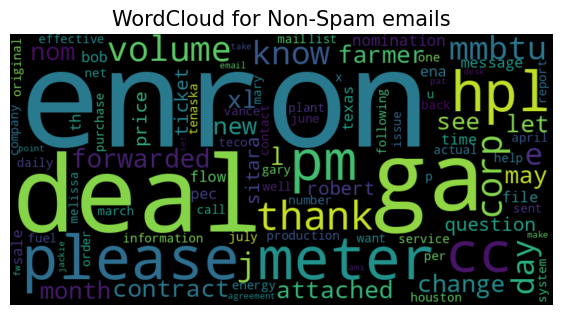

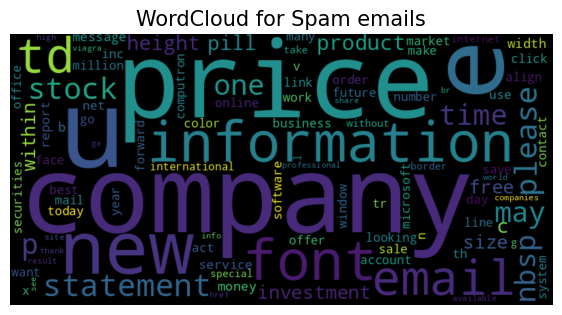

In [ ]:
# Creating a word cloud visual of the most common words/tokens within each eamil type
email_corpus = " ".join(data[data['Category'] == 0]['Message'])
plt.figure(figsize=(7, 7))
wc = WordCloud(background_color='black',
               max_words=100,
               width=800,
               height=400,
               collocations=False).generate(email_corpus)

plt.imshow(wc, interpolation='bilinear')
plt.title(f'WordCloud for Non-Spam emails', fontsize=15)
plt.axis('off')
plt.show()



email_corpus = " ".join(data[data['Category'] == 1]['Message'])
plt.figure(figsize=(7, 7))
wc = WordCloud(background_color='black',
               max_words=100,
               width=800,
               height=400,
               collocations=False).generate(email_corpus)

plt.imshow(wc, interpolation='bilinear')
plt.title(f'WordCloud for Spam emails', fontsize=15)
plt.axis('off')
plt.show()

In [ ]:
#train test split, using an 80/20 training data/testing data split
train_X, test_X, train_Y, test_Y = train_test_split(data['Message'],
                                                    data['Category'],
                                                    test_size = 0.2,
                                                    random_state = 42)

In [ ]:
train_Y.head()

2221    1
4267    0
100     0
12      0
2470    0
Name: Category, dtype: int64

In [ ]:
print("train_X.shape: ", train_X.shape)
print("test_X.shape:  ", test_X.shape)
print("train_Y.shape: ", train_Y.shape)
print("test_Y.shape:  ", test_Y.shape)

train_X.shape:  (3584,)
test_X.shape:   (897,)
train_Y.shape:  (3584,)
test_Y.shape:   (897,)


In [ ]:
# Tokenize the data and preparing it for modeling
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Since each of the emails are of different lengths, and some very long, I included a variable that says what the maxium sequence length can be for the modeling process
max_len = 100
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')
test_sequences = pad_sequences(test_sequences,
                               maxlen=max_len,
                               padding='post',
                               truncating='post')

**Model Development and Evaluation**

In [ ]:
# Building the TensorFlow model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32,
                                    input_length=max_len))
# Here you can control the number of layers/parameters that your model has. The more parameters = higher complexity and slower runtime of the model, but may also result in better model accuracy
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           1259648   
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,263,361
Trainable params: 1,263,361
Non-trainable params: 0
_________________________________________________________________


**Callbacks & EarlyStoping**

In building the model, we are able to specify the number of epochs and the batch size that is used to contorl how accurate and speed in which the model will be trained. Additionally, we are able to specify


Using EarlyStopping and ReduceLROnPlateau we can specify if we want the model to end early based on whether the model is improving at a certain rate or not.

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')

In [ ]:
es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [ ]:
# Train the model
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20,
                    batch_size=32,
                    callbacks = [lr, es]
                   )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


112/112 [==============================] - 11s 75ms/step - loss: 0.5659 - accuracy: 0.7316 - val_loss: 0.2270 - val_accuracy: 0.9487 - lr: 0.0010
Epoch 2/20
112/112 [==============================] - 6s 54ms/step - loss: 0.1596 - accuracy: 0.9601 - val_loss: 0.2277 - val_accuracy: 0.9409 - lr: 0.0010
Epoch 3/20
112/112 [==============================] - 8s 75ms/step - loss: 0.1376 - accuracy: 0.9690 - val_loss: 0.2108 - val_accuracy: 0.9487 - lr: 0.0010
Epoch 4/20
112/112 [==============================] - 7s 65ms/step - loss: 0.1117 - accuracy: 0.9763 - val_loss: 0.2147 - val_accuracy: 0.9465 - lr: 0.0010


In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

print(f'\nThe training accuracy turns out to be {test_accuracy*100:.2f}%, which seems pretty good.')

29/29 [==============================] - 0s 14ms/step - loss: 0.2270 - accuracy: 0.9487
Test Loss : 0.22700761258602142
Test Accuracy : 0.9487179517745972

The training accuracy turns out to be 94.87%, which seems pretty good.


# Feature Experiments using varied input data

In [ ]:
#experiment 1: use two different sets of features
#stopwords/alpha chars - compare experiment results

#experiment 2: use two different sets of features
#unigrams, bigrams, trigrams - compare experiment results

#experiment 3: use two different sets of features
#sentiment analysis - compare experiment results

#experiment 4: use two different sets of features
#vocabulary size - compare experiment results

#experiment 5: use at least two combined feature functions
#bigrams + sentiment analysis?

#experiment 7: use an advanced function
# Bryan - Using TensorFlow to Detect Spam Emails